# **Overview**

Sentiment analysis, a facet of Natural Language Processing, encompasses a range of methodologies designed to derive subjective insights from text or speech, including viewpoints and emotional tones. In essence, it revolves around categorizing text into positive, negative, or neutral sentiments.

Problem Statement:
The core aim of this endeavor is the identification and categorization of hate speech within tweets. To streamline the task, we define a tweet as being indicative of hate speech if it exhibits either racist or sexist sentiments.

The main objective of this project is to detect instances of hate speech within tweets. To simplify the task, we consider a tweet to contain hate speech if it expresses either racist or sexist sentiments.

To provide further details, this research is also be provided with a training dataset that includes tweets along with corresponding labels. Consequently, the task revolves around classifying tweets into three distinct categories:using the labels 'positive' will correspond to '2,' 'negative' to '1,' and 'neutral' to '0'.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

#For Preprocessing
import re    # RegEx for removing non-letter characters
import pickle
import nltk  #natural language processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
from gensim import models
from sklearn.preprocessing import LabelEncoder

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import seaborn as sns
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


# **Exploratory Data Analysis**

# Data Review

In [ ]:
# Load dataset
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)
# Output first five rows
df.columns =['text', 'label']
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [ ]:
#Size of the data
df.shape

(11000, 2)

In [ ]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


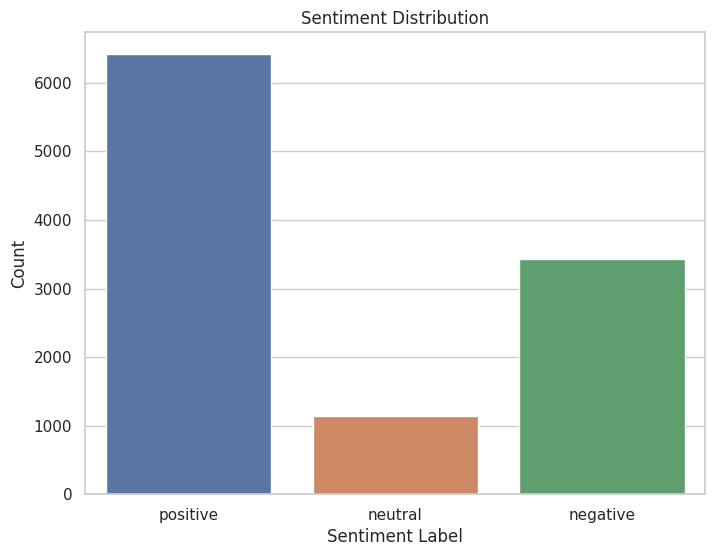

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [ ]:
# Visualize sentiment using a count plot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

df.label.value_counts()

# **Text Normalization/Cleansing**

The textual content frequently comprises hyperlinked text, emoticons, and punctuation marks. To facilitate their utilization for educational purposes via a Language Model, the incorporation of such content into the model's training data is impermissible. Consequently, it becomes necessary to undertake the purification of the textual data through the employment of diverse preprocessing and cleansing methodologies.

In [ ]:
# Data Cleansing
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

def remove_unnecessary_char(text):
    # Remove unnecessary characters
    text = re.sub(r"\n", "", text)
    # Remove every username
    text = re.sub(r"user", "", text)
    # Remove URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text)
    # Split a String
    text = re.sub(r"\s+", " ", text)
    # return list
    return text

# remove stopwords
# nltk.download('stopwords')
# stop = set(stopwords.words("indonesian"))
# def remove_stopwords(text):
#     filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
#     return " ".join(filtered_words)

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    # text = remove_stopwords(text) # 3
    return text

In [ ]:
#Text already clean
df['text_clean'] = df.text.apply(preprocess)
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


# **Data Processing**

# *Categorization of Textual Data into 3 Sentiments and Data Preparation for Analysis.*
1. Sorting Sentences: This code organizes sentences based on whether they express positive, neutral, or negative feelings.
2. Counting Them: It then counts how many sentences are in each feeling group.
3. Combining Everything: All the sentences and their counts are put together in one place.
4. Preparing for Learning: Finally, the data is made ready for a computer to learn patterns from the sentences.

In [ ]:
# Extract preprocessed text data based on "3 sentiment categories"
negative_texts = df.loc[df['label'] == 'negative'].text_clean.tolist()
neutral_texts = df.loc[df['label'] == 'neutral'].text_clean.tolist()
positive_texts = df.loc[df['label'] == 'positive'].text_clean.tolist()

# Extract labels corresponding to different sentiments
negative_labels = df.loc[df['label'] == 'negative'].label.tolist()
neutral_labels = df.loc[df['label'] == 'neutral'].label.tolist()
positive_labels = df.loc[df['label'] == 'positive'].label.tolist()

# Combine text data and labels for all sentiments
all_texts = positive_texts + neutral_texts + negative_texts
all_labels = positive_labels + neutral_labels + negative_labels

# Count examples for each sentiment category and determine total data size
num_positive = len(positive_texts)
num_neutral = len(neutral_texts)
num_negative = len(negative_texts)
total_data = len(all_texts)

# Display information about data distribution
print(f'Number of Examples with Positive Sentiment: {num_positive}')
print(f'Number of Examples with Neutral Sentiment: {num_neutral}')
print(f'Number of Examples with Negative Sentiment: {num_negative}')
print(f'Total Number of Data Examples: {total_data}')

Number of Examples with Positive Sentiment: 6416
Number of Examples with Neutral Sentiment: 1148
Number of Examples with Negative Sentiment: 3436
Total Number of Data Examples: 11000


# Tokenization

In [ ]:
# Tokenization and Vocabulary Creation
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(all_texts)
X = tokenizer.texts_to_sequences(all_texts)
X = pad_sequences(X)
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Label Encoding
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(all_labels)
Y = to_categorical(Y, num_classes=3)  # Convert to one-hot encoded labels

By saving the label encoder, tokenizer, and processed data, it can create a snapshot of entire data preprocessing pipeline. This is particularly useful to deploy the model in a different environment or share it with others, ensuring that the preprocessing steps are consistent with what the model was trained on.

Remember to load these saved components when you want to evaluate your model on new data or deploy it for predictions. it can use the pickle module's load function to load the saved objects back into the code.

In [ ]:
X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

Y = pd.get_dummies(all_labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

x_pad_sequences.pickle has created!
y_labels.pickle has created!


In [ ]:
#Split Dataset For Training & Testing
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

# Neural Network Model

In [ ]:
print(X_train.shape)

(8800, 96)


In [ ]:
import numpy as np
import pandas as pd
import pickle
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create a Keras Sequential model
model = Sequential()
model.add(Dense(128, input_dim=maxlen, activation='relu'))  # Adjust input_dim
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes for sentiment

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on your data
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_labels, Y_pred_labels))

# Save the Keras model as an HDF5 file
model.save('sentiment_mlp_model.h5')
print("Keras model saved as 'sentiment_mlp_model.h5'")


Epoch 1/10
248/248 [==============================] - 3s 5ms/step - loss: 132.9773 - accuracy: 0.4761 - val_loss: 78.3670 - val_accuracy: 0.4705
Epoch 2/10
248/248 [==============================] - 1s 3ms/step - loss: 43.9977 - accuracy: 0.5400 - val_loss: 52.4691 - val_accuracy: 0.4841
Epoch 3/10
248/248 [==============================] - 1s 3ms/step - loss: 24.7426 - accuracy: 0.5713 - val_loss: 39.8092 - val_accuracy: 0.4636
Epoch 4/10
248/248 [==============================] - 1s 2ms/step - loss: 16.2096 - accuracy: 0.5913 - val_loss: 30.7463 - val_accuracy: 0.4989
Epoch 5/10
248/248 [==============================] - 1s 2ms/step - loss: 10.5710 - accuracy: 0.6136 - val_loss: 23.6802 - val_accuracy: 0.5000
Epoch 6/10
248/248 [==============================] - 1s 2ms/step - loss: 7.1577 - accuracy: 0.6404 - val_loss: 22.4083 - val_accuracy: 0.5057
Epoch 7/10
248/248 [==============================] - 1s 2ms/step - loss: 5.4244 - accuracy: 0.6490 - val_loss: 16.4466 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# *Confusion Matrix*
Confusion Matrix provide a nice overlook at the model's performance in classification task

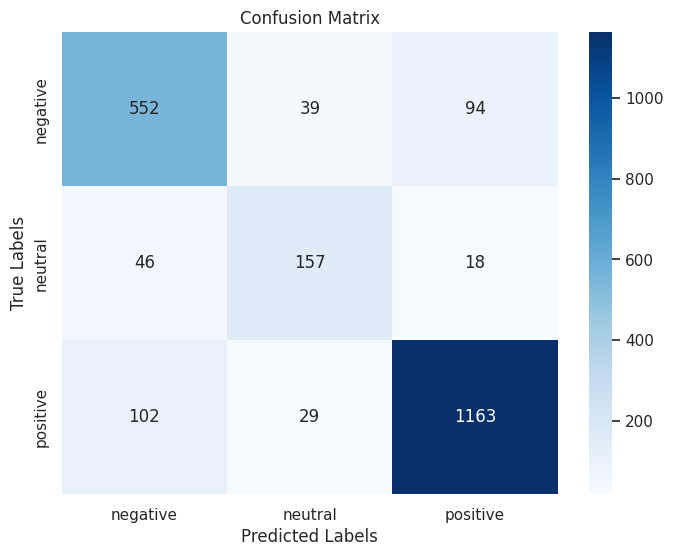

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Model Testing

In [ ]:
# Sample input text
input_text = """
Rasa syukur, cukup.
"""

# Define a function to clean and preprocess the input text
def clean_text(text):
    # Convert text to lowercase using the lower() function
    cleaned_text = text.lower()
    # Remove emoticons and punctuation using "RegEx" with the script below
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', ' ', cleaned_text)
    return cleaned_text

# Define the possible sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Clean and preprocess the input text
text = [clean_text(input_text)]

# Load the trained model
model_name = "mlp_model"
model = load_model(model_name + '.h5')

# Tokenize and pad the input text for prediction
predicted = tokenizer.texts_to_sequences(text)
# X.shape[1] matches the model input length
guess = pad_sequences(predicted, maxlen=X.shape[1])
# Make predictions using the loaded model
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

# Print the cleaned input text and the predicted sentiment label
print("Cleaned Text: ", text[0])
print("Predicted Sentiment: ", sentiment_labels[polarity])


1/1 [==============================] - 0s 128ms/step
Cleaned Text:   rasa syukur  cukup  
Predicted Sentiment:  neutral
